In [98]:
import pandas as pd
from preprocessing import load_data, filter_tags

In [99]:
df_recipes = load_data("RAW_recipes.csv")
df_recipes = filter_tags(df_recipes, ["beverages"])
# df_recipes.info()

## Ingredients extraction
#### LLAMA3 set up
1. Download from https://ollama.com/
2. Install
3. Click here http://localhost:11434/ to check if it’s running (it should appear 'Ollama is running')
4. Run in a terminal: `ollama run llama3`

If u dont have: `pip install langchain-community`

In [100]:
from langchain_community.llms import Ollama
from collections import Counter
from preprocessing import *
import re

llm = Ollama(model="llama3")
sentences = ["I have tomatoes, onions, and garlic. What can I cook with them?",
             "What dishes can I make with pasta, spinach, and cheese?",
             "I found some shrimp, bell peppers, and mushrooms in the fridge. Any recipe suggestions?",
             "My pantry has rice, beans, and tomatoes. What's a simple yet delicious meal I can prepare?",
             "I have eggs, bacon, and bread. How can I turn these into a tasty breakfast?",
             "What can I whip up with ground beef, bell peppers, and onions?",
             "I bought salmon, asparagus, and lemon. What's a good recipe for a healthy dinner?",
             "I've got tofu, broccoli, and soy sauce. Any suggestions for a vegetarian stir-fry?",
             "What desserts can I make with flour, sugar, and chocolate?",
             "I'm craving something sweet. What can I make with apples, cinnamon, and oats?"]


the LLM approach could look like:
prompt:
List all food ingredients from the following text {{user prompt}

In [101]:

def extractIngredients(sentence):
    output = ''
    prompt = f"Output the ingredients from the following sentence without any comments, separated only by white spaces: {sentence}"
    for chunks in llm.stream(prompt):
        output += chunks

    pattern = r'\b[a-zA-Z]+\b'  # Simple pattern to match words
    ingredients = list(re.findall(pattern, output.lower()))
    print(f"Found ingredietns: {ingredients}")
    return ingredients


# Extract and count all the ingredients form a DF
def extract_info_form_df(df, info='ingredients'):
    df_food = filter_tags(df,["beverages"])
    df_food.reset_index(drop=True, inplace=True)
    ingredients = df_food[info]#.iloc[0:1000]
    all_ingredients = np.concatenate(ingredients)
    all_ingredients_counter = Counter(all_ingredients)  
    return all_ingredients_counter

import ast

# To convert the string of ingredients to a list of ingredients
def convert_strings_to_lists(string_list):
    try:
        return ast.literal_eval(string_list)
    except Exception as e:
        print(f"Error converting string to list: {string_list}")
        return []

In [102]:
# for sent in sentences:
#     print(f"sent: {sent}\nIngred:{extractIngredients(sent)}")

### Cosine Similarity apporach

- https://www.datastax.com/guides/what-is-cosine-similarity
- https://www.geeksforgeeks.org/what-is-text-analytics/

1. Vectorize the Ingredients: Convert the list of ingredients for each recipe and the extracted ingredients into vectors.
2. only transform the user’s ingredients into a vector and compare that to the vectors of the recipes
3. Compute Cosine Similarity: Compute the cosine similarity between the extracted ingredients' vector and the ingredients' vector for each recipe.
4. Sort by Similarity: Sort the recipes based on their similarity scores and select the top matches.

This version of the function uses TruncatedSVD for dimensionality reduction and adjusts the parameters of the TfidfVectorizer for potentially better results. The optimal number of components for TruncatedSVD and the parameters for TfidfVectorizer may vary depending on the task/sataset.

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

def clean_dataframe(df):
    # Drop rows with NaN values in 'ingredients' column
    df = df.dropna(subset=['ingredients'])
    # Convert ingredients column from string to list
    df['ingredients'] = df['ingredients'].apply(lambda x: eval(x) if isinstance(x, str) else x)
    # Filter out rows where ingredients are not lists or contain NaN
    df = df[df['ingredients'].apply(lambda x: isinstance(x, list) and all(isinstance(i, str) for i in x))]
    return df

def process_list(ingredient_list):
    return [s.lower() if isinstance(s, str) else s for s in ingredient_list]

def preprocess(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([c for c in text if c.isalnum() or c.isspace()])
    return text


# only transform the user’s ingredients into a vector and compare that to the vectors of the recipes
# ids = ids to exclude from df
def get_most_likely_recipes(user_ingredients, df, ids=[], top_n=5, n_components=100):

    # Preprocess user input ingredients
    user_ingredients = [preprocess(ingredient) for ingredient in user_ingredients]
    user_ingredients_str = ' '.join(user_ingredients)

    df = clean_dataframe(df)
    df = df.dropna(subset=['ingredients'])

    # Remove from the DF the recipes with the id contained in ids (to evaluate)
    if len(ids) != 0: df = df[~df['id'].isin(ids)]

    # Convert list of ingredients to strings
    df['ingredients_str'] = df['ingredients'].apply(lambda x: ' '.join([preprocess(ingredient) for ingredient in x]))
    df = df.dropna(subset=['ingredients_str'])

    # Create the TfidfVectorizer instance
    vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.95).fit(df['ingredients_str'])
    vectors = vectorizer.transform(df['ingredients_str'])

    # Dimensionality reduction
    svd = TruncatedSVD(n_components=n_components)
    vectors_svd = svd.fit_transform(vectors)

    # Transform user's ingredients into a vector
    user_vector = vectorizer.transform([user_ingredients_str])
    user_vector_svd = svd.transform(user_vector)

    # Compute cosine similarity
    cosine_sim = cosine_similarity(user_vector_svd, vectors_svd).flatten()

    # Get top_n recipes with highest similarity scores
    top_indices = cosine_sim.argsort()[-top_n:][::-1]
    top_recipes = df.iloc[top_indices]

    # for score, recipe in zip(cosine_sim, top_recipes['name']):
    #     print(f"Recipe: {recipe},\t Similarity Score: {score}")
    
    return top_recipes

## Evaluation

The following function builds a vector of list: each list contains the ingredients from the DB [0:100]; with those we automatically generated 100 user inputs that contains those ingredients.

In [104]:
ground_truth = []
for ingredient in df_recipes['ingredients'].iloc[:73]: # Depending on the range, different lists can be outputted 
    # temp = convert_strings_to_lists(ingredient)
    ground_truth.append(ingredient)
print(ground_truth)

[['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt'], ['prepared pizza crust', 'sausage patty', 'eggs', 'milk', 'salt and pepper', 'cheese'], ['ground beef', 'yellow onions', 'diced tomatoes', 'tomato paste', 'tomato soup', 'rotel tomatoes', 'kidney beans', 'water', 'chili powder', 'ground cumin', 'salt', 'lettuce', 'cheddar cheese'], ['spreadable cheese with garlic and herbs', 'new potatoes', 'shallots', 'parsley', 'tarragon', 'olive oil', 'red wine vinegar', 'salt', 'pepper', 'red bell pepper', 'yellow bell pepper'], ['tomato juice', 'apple cider vinegar', 'sugar', 'salt', 'pepper', 'clove oil', 'cinnamon oil', 'dry mustard'], ['fennel seeds', 'green olives', 'ripe olives', 'garlic', 'peppercorn', 'orange rind', 'orange juice', 'red chile', 'extra virgin olive oil'], ['pork spareribs', 'soy sauce', 'fresh garlic', 'fresh ginger', 'chili powder', 'fresh coarse ground black pepper', 'salt', 'fresh cilantro leaves', 'tomato sauce', 'brown sugar'

In [105]:
# Generated by GPT
user_inputs = [
    "What can I cook with winter squash, mexican seasoning, mixed spice, honey, butter, olive oil, and salt?",
    "Can you suggest a recipe using prepared pizza crust, sausage patty, eggs, milk, salt and pepper, and cheese?",
    "What dish can I make with ground beef, yellow onions, diced tomatoes, tomato paste, tomato soup, rotel tomatoes, kidney beans, water, chili powder, ground cumin, salt, lettuce, and cheddar cheese?",
    "I'd like to cook something with spreadable cheese with garlic and herbs, new potatoes, shallots, parsley, tarragon, olive oil, red wine vinegar, salt, pepper, red bell pepper, and yellow bell pepper. Any ideas?",
    "How can I use tomato juice, apple cider vinegar, sugar, salt, pepper, clove oil, cinnamon oil, and dry mustard in a recipe?",
    "Do you have a recipe that includes milk, vanilla ice cream, frozen apple juice concentrate, and apple?",
    "What can I make with fennel seeds, green olives, ripe olives, garlic, peppercorn, orange rind, orange juice, red chile, and extra virgin olive oil?",
    "Can you suggest a dish using pork spareribs, soy sauce, fresh garlic, fresh ginger, chili powder, fresh coarse ground black pepper, salt, fresh cilantro leaves, tomato sauce, brown sugar, yellow onion, white vinegar, honey, A.1. original sauce, liquid smoke, cracked black pepper, cumin, dry mustard, cinnamon sticks, orange juice, mirin, and water?",
    "I have chocolate sandwich style cookies, chocolate syrup, vanilla ice cream, bananas, strawberry ice cream, and whipped cream. What can I make?",
    "What can I bake with sugar, unsalted butter, bananas, eggs, fresh lemon juice, orange rind, cake flour, baking soda, and salt?",
    "Can you suggest a recipe using whole berry cranberry sauce, sour cream, and prepared horseradish?",
    "I need a recipe that includes vanilla wafers, butter, powdered sugar, eggs, whipping cream, strawberry, and walnuts.",
    "How can I use great northern bean, chicken bouillon cubes, dark brown sugar, molasses, cornstarch, onion, garlic powder, mustard powder, chili powder, salt, black pepper, bacon, and water in a recipe?",
    "What can I cook with collard greens, brown sugar, molasses, hot sauce, whiskey, and ham hock?",
    "Do you have a recipe that includes gentian root, scullcap herb, burnet root, wood bethony, and spearmint?",
    "What can I make with lean pork chops, flour, salt, dry mustard, garlic powder, oil, and chicken rice soup?",
    "Can you suggest a dish using egg roll wrap, whole green chilies, cheese, cornstarch, and oil?",
    "I'd like to cook something with butterscotch chips, Chinese noodles, and salted peanuts. Any ideas?",
    "How can I use celery, onion, ground pork, soy sauce, beef broth, cooking oil, and hamburger buns in a recipe?",
    "What can I make with canola oil, onion, garlic, cauliflower, potatoes, vegetable bouillon cubes, water, salt free herb and spice seasoning mix, ground coriander, great northern bean, salt and pepper, broccoli floret, escarole, green peas, red bell pepper, and fresh herb?",
    "Can you suggest a recipe using water, salt, boiling potatoes, fresh spinach leaves, unsalted butter, coarse salt, fresh ground black pepper, and nutmeg?",
    "I need a dish that includes onion, scallion, apple juice, olive oil, spinach, fresh parsley, celery, broth, rolled oats, salt, dried thyme, and white pepper.",
    "What can I cook with boneless skinless chicken breast halves, condensed cream of chicken soup, egg, seasoning salt, all-purpose flour, cornstarch, garlic powder, paprika, salt and pepper, and oil?",
    "Can you suggest a recipe using all-purpose flour, granulated sugar, baking powder, salt, vanilla extract, egg, milk, vegetable oil, bread, brown sugar, ground cinnamon, butter, and powdered sugar?",
    "How can I use butter, lemon juice, salt, white pepper, and egg yolks in a dish?",
    "What can I make with ground black pepper, ground ginger, ground coriander, ground cumin, ground turmeric, and black cumin?",
    "I'd like to cook something with vegetarian ground beef, garlic, onion, jalapenos, green pepper, celery, kidney beans, diced tomatoes, chili powder, black pepper, salt, and red pepper flakes. Any ideas?",
    "What can I make with beef stew meat, water, tomatoes, beef bouillon cube, onion, dried parsley, salt, ground thyme, ground pepper, zucchini, cabbage, garbanzo beans, elbow macaroni, and parmesan cheese?",
    "Do you have a recipe that includes red potatoes and margarine, and rosemary?",
    "What dish can I make with unsalted butter, carrot, onion, celery, broccoli stem, dried thyme, dried oregano, dried sweet basil leaves, dry white wine, chicken stock, Worcestershire sauce, Tabasco sauce, smoked chicken, black beans, broccoli floret, heavy cream, salt & fresh ground pepper, and cornstarch?",
    "What can I bake with butter, sugar, vanilla, eggs, all-purpose flour, baking cocoa, baking powder, salt, and miniature peppermint patties?",
    "Can you suggest a recipe using ground beef, onion, tomato sauce, taco sauce, salt, pepper, Tabasco sauce, hot chili pepper, cornmeal, whole kernel corn, sliced ripe olives, and cheddar cheese?",
    "How can I use butter, dry ranch dressing mix, and French bread in a recipe?",
    "I need a dish that includes ground venison, egg substitute, non-fat powdered milk, water, fresh breadcrumb, onion, salt, black pepper, dry mustard, and Worcestershire sauce.",
    "What can I make with milk, frozen juice concentrùate, and plain yogurt?",
    "Can you suggest a recipe using low sodium chicken broth, diced tomatoes, zucchini, corn, potatoes, wax beans, green beans, and carrots?",
    "What dish can I make with frozen chopped spinach, egg, salt, black pepper, onion, sharp cheddar cheese, condensed cream of mushroom soup, and crouton?",
    "What can I cook with red potatoes, green onion, diced pimentos, fat-free mayonnaise, plain low-fat yogurt, low-fat sour cream, sugar, prepared mustard, white wine vinegar, salt, pepper, celery seed, and garlic?",
    "Can you suggest a recipe using frozen chopped spinach, eggs, garlic powder, soft breadcrumbs, oregano, margarine, sage, and onion?",
    "What dish can I make with ground beef, onion, frozen vegetables, cream of mushroom soup, condensed cream of mushroom & garlic soup, salt & pepper, cooking oil, and cornbread mix?",
    "I'd like to cook something with angel hair pasta, toasted sesame oil, soy sauce, honey, garlic, green onions, toasted sesame seeds, and stir fry vegetables. Any ideas?",
    "Can you suggest a recipe using all-purpose flour, buckwheat flour, unsweetened cocoa, baking powder, baking soda, salt, ground cinnamon, ground cloves, honey, sugar, eggs, yam, low-fat buttermilk, orange rind, orange juice, canola oil, brown sugar, flour, cinnamon, butter, and pecans?",
    "What can I bake with all-purpose flour, buckwheat flour, unsweetened cocoa, baking powder, baking soda, salt, ground cinnamon, ground cloves, sorghum, eggs, yam, low-fat buttermilk, orange rind, orange juice, canola oil, raisins, boiling water, and granulated sugar?",
    "How can I use ground beef, sugar, prepared yellow mustard, beer, cayenne, garlic, salt & pepper, and American cheese in a recipe?",
    "What can I make with tri-color spiral pasta, dill pickles, ripe olives, green onion, chives, sweet pepper, water chestnut, tomatoes, ham, cheese, olive oil, cider vinegar, onion powder, garlic powder, salt and pepper, and Italian seasoning?",
    "Do you have a recipe that includes frozen French fries, oil, salt & freshly ground black pepper, parmesan cheese, oregano, basil, and flat leaf parsley?",
    "What dish can I make with sandwich bun, Good Seasonings Italian salad dressing mix, butter, deli turkey, ham, pepperoni, cheddar cheese, Swiss cheese, and mozzarella cheese?",
    "How can I use shortening, icing sugar, vanilla, all-purpose flour, baking powder, sugar, eggs, salt, milk, and butter in a recipe?",
    "What can I bake with yellow cake mix, vanilla instant pudding mix, nutmeg, cinnamon, eggs, oil, water, crushed pineapple, carrot, pecans, and coconut?",
    "Can you suggest a recipe using whole kernel corn, onion, red bell pepper, butter, Jiffy corn muffin mix, egg, heavy cream, jalapenos, sharp cheddar cheese, and honey?",
    "What dish can I make with flour, water, dry yeast, milk, sugar, eggs, vegetable oil, baking soda, baking powder, salt, cinnamon, vanilla, crushed pineapple, raisins, nuts, butter, and brown sugar?",
    "I'd like to cook something with Italian sausage, ground beef, garlic, dried basil, salt, whole tomato, tomato paste, ricotta cheese, cottage cheese, parmesan cheese, parsley flakes, eggs, ground black pepper, lasagna noodles, mozzarella cheese, and mushrooms. Any ideas?",
    "Can you suggest a recipe using margarine, sugar, eggs, lemon extract, self-rising flour, evaporated milk, and flaked coconut?",
    "How can I use chicken tenders, egg, butter, flour, milk, dried parsley, lemon, salt, pepper, and heavy cream in a dish?",
    "What can I make with green onions, snow peas, mung bean sprout, carrot, water chestnut, oil, soy sauce, cornstarch, pork butt, flour, garlic powder, and ginger?",
    "What dish can I make with hamburger bun, pork patty, egg, and cheese slice?",
    "Can you suggest a recipe using instant tea, sugar, cinnamon, cloves, and nutmeg?",
    "What can I make with ground beef, cream of mushroom soup, evaporated milk, beef broth, garlic powder, onion powder, parsley, pepper, and noodles?",
    "How can I use chicken stock, potatoes, corn kernels, flour, heavy cream, black pepper, ground thyme, onion, and butter in a dish?",
    "What dish can I make with cream of mushroom soup, cream of celery soup, frozen peas, celery, milk, thyme, paprika, salt, black pepper, and canned salmon?",
    "Can you suggest a recipe using chicken, garlic, soy sauce, dried oregano, salt, fresh ground black pepper, canola oil, tomato, onion, chicken broth, cumin, fresh cilantro, avocado, lime, tortilla, and shredded cheddar cheese?",
    "I'd like to cook something with red potatoes, carrots, red onion, zucchini, butter, fresh parsley, and salt. Any ideas?",
    "What can I bake with graham cracker crust, sweetened condensed milk, lime juice, sour cream, and lime peel?",
    "Can you suggest a recipe using frozen apple juice concentrate, chicken broth, Dijon mustard, molasses, and cornstarch?",
    "What dish can I make with vanilla instant pudding mix, vanilla extract, milk, cream cheese, powdered sugar, lemon, and condensed milk?",
    "How can I use potatoes, onions, and cheddar cheese in a recipe?",
    "What can I cook with broccoli florets, butter, cream of chicken soup, American cheese, cheddar cheese, milk, salt, and pepper?",
    "Can you suggest a recipe using ground beef, onion, potato, chili powder, salt, tomato, and lettuce?",
    "What dish can I make with eggs, powdered sugar, butter, evaporated milk, and vanilla?",
    "How can I use graham cracker crust, sweetened condensed milk, lime juice, sour cream, and lime peel in a dish?",
    "What can I make with chicken broth, fresh mushrooms, butter, flour, cream, salt, fresh ground black pepper, dried dill, and lemon juice?",
    "Can you suggest a recipe using vanilla instant pudding mix, vanilla extract, milk, cream cheese, powdered sugar, lemon, and condensed milk?",
    "How can I use pork patty, hamburger bun, egg, and cheese slice in a dish?"
]

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns


# take 2 lists of ingredients and output the %
# Computing how much % of the user ingredients are present in the output recepie
def computePercIngredients(user_ingredients, output_ingredients):
    set1 = set(user_ingredients)
    set2 = set(output_ingredients)

    if not set1: return 0.0, 100.0
    if not set2: return 0.0, 0.0

    common_ingredients  = set1.intersection(set2)
    missing_ingredients = set2.difference(set1)

    # print(f"S1:  {list(set1)}")
    # print(f"S2:  {list(set2)}")
    print(f"Common:  {list(common_ingredients)}")
    print(f"Missing: {list(missing_ingredients)}")

    percentage_overlap = (len(common_ingredients)  / len(set1)) * 100
    percentage_missing = (len(missing_ingredients) / len(set2)) * 100

    return percentage_overlap, percentage_missing

def plot_ingredient_percentages(matching_percentages, missing_percentages):
    plt.figure(figsize=(14, 7))
    sns.set_style("whitegrid")
    
    x = list(range(1, len(matching_percentages) + 1))
    
    plt.plot(x, matching_percentages, label='Matching %', marker='o', linestyle='-', color='g')
    plt.plot(x, missing_percentages, label='Missing %', marker='x', linestyle='-', color='r')
    
    plt.title('Model Performance: Matching and Missing Ingredients per Recipe', fontsize=16, fontweight='bold')
    plt.xlabel('Recipes', fontsize=14, fontweight='bold')
    plt.ylabel('\% of ingredients ', fontsize=14, fontweight='bold')

    plt.xticks(ticks=range(0, len(x), 5), fontsize=12)
    
    plt.legend(fontsize=12, title='Legend', title_fontsize='15', loc='upper right')
    plt.show()

In [62]:
def evaluate(ground_truth, model_ingredients):
    print(f"Ground Truth: {len(ground_truth)}\nModel: {len(model_ingredients)}")
    percMatching = []
    percMissing  = []
    for idx, ingred in enumerate(ground_truth):
        model_ing = model_ingredients[idx]
        print(f"G: {ingred}\nM: {model_ing}")
        percOverlap, percDifference = computePercIngredients(ingred, model_ing)
        percMatching.append(percOverlap)
        percMissing.append(percDifference)

    plot_ingredient_percentages(percMatching, percMissing)

Retrieve the groudn trouth of ingredients from the file 'recipes_test.json': the # of ingredients is defined by 'n_cases' and the selection is random.

In [108]:
import json
import random as r
from preprocessing import load_data, filter_tags


df = load_data("filtered_recipes.csv", preprocess_steps=True)
df = filter_tags(df,["beverages"])

with open('recipes_test.json', 'r') as f:
    data = json.load(f)

In [109]:
n_cases     = 100     # How many lists of ingredients
idx_set     = []      # The set of the ID of the selected recipes (to avoid to select one recipe twice)
df_selected = pd.DataFrame(index = range(n_cases), columns=['instruction', 'input', 'output'])

ground_truth = []
# Retrieves ingredients from json file, with the assumptions that the ingredients are stored
# as a string, each ingredient is separated by ', ' and that are stored in the ['input'] field
for i in range(n_cases):
    idx = r.randint(0, len(data)-1)

    # Generate an index if the selected one has already been choosen
    while idx in idx_set:
        idx = r.randint(0, len(data)-1)

    df_selected.loc[i] = data[idx]
    ground_truth.append(data[idx]['input'] .split(', '))
    idx_set.append(idx)

In [110]:
def create_numbered_steps(lst):
    return '\n'.join([f"{i+1}. {step}" for i, step in enumerate(lst)])

def get_ids_to_exclude(df, df_recipes_test):
    df_temp = df.copy()
    df_temp['steps_temp'] = df_temp['steps'].apply(create_numbered_steps)

    ids = []
    for i in range(len(df_recipes_test)):
        matches = df_temp[df_temp['steps_temp'] == df_recipes_test["output"][i]]
        id = list(matches["id"])
        ids += id
    return ids

In [111]:
ids = get_ids_to_exclude(df, df_selected)
# print(ids)

Saving variables to evaluate the method

In [112]:
recipes = []
steps   = []
output_ingredients = []

for ingred in ground_truth:
    recipe = get_most_likely_recipes(ingred, df, ids, 1)
    # print(f"Ingredients: \t{ingred}\nRecipe: {recipe['name']}\n{recipe['id'].isin(ids)}\n")

    recipes.append(recipe)
    steps.append(recipe['steps'])
    output_ingredients.append(list(recipe['ingredients'].iloc[0]))

Ground Truth: 100
Model: 100
G: ['all-purpose flour', 'baking soda', 'baking powder', 'sugar', 'salt', 'eggs', 'buttermilk', 'sour cream', 'butter', 'vanilla']
M: ['sugar', 'butter', 'baking powder', 'flour', 'vanilla', 'eggs', 'baking soda', 'salt', 'sour cream']
Common:  ['eggs', 'vanilla', 'sugar', 'baking soda', 'butter', 'baking powder', 'salt', 'sour cream']
Missing: ['flour']
G: ['oatmeal', 'cottage cheese', 'vanilla', 'egg whites']
M: ['low fat cottage cheese', 'oatmeal', 'egg whites', 'vanilla']
Common:  ['oatmeal', 'vanilla', 'egg whites']
Missing: ['low fat cottage cheese']
G: ['bisquick', 'buttermilk', 'cheddar cheese', 'margarine', 'garlic powder', 'dried parsley flakes']
M: ['bisquick reduced-fat baking mix', 'low-fat buttermilk', 'low-fat cheddar cheese', 'fat-free margarine', 'garlic powder', 'dried parsley flakes']
Common:  ['garlic powder', 'dried parsley flakes']
Missing: ['fat-free margarine', 'bisquick reduced-fat baking mix', 'low-fat cheddar cheese', 'low-fat but

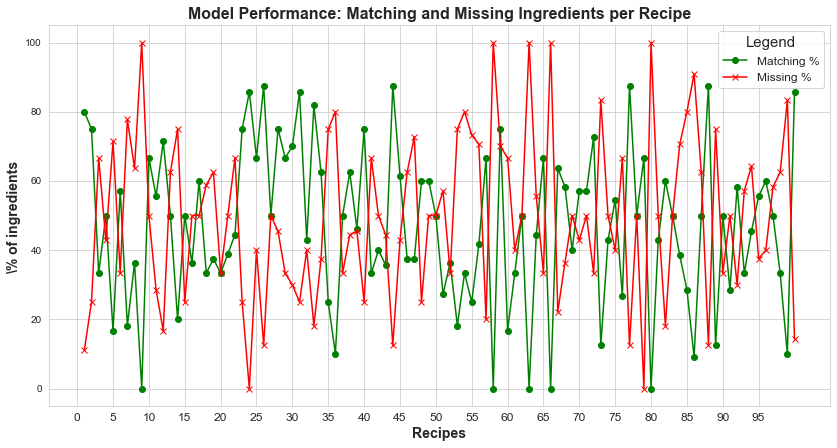

In [113]:
evaluate(ground_truth, output_ingredients)

### EVALUATION ON TESTS

In [33]:
import pickle


with open("recipe_evaluation_all_fixed.pkl", 'rb') as f:
    recipes_evaluation_data = pickle.load(f)
print(type(recipes_evaluation_data['levenstein_results']))
print(recipes_evaluation_data['inputs'])
# print((recipes_evaluation_data.keys()))

<class 'list'>
[['sugar', 'vegetable oil', 'eggs', 'vanilla', 'zucchini', 'applesauce', 'orange juice', 'flour', 'baking soda', 'baking powder', 'salt', 'nutmeg', 'cinnamon', 'walnuts'], ['white chocolate baking squares', 'nutter butter sandwich cookies', 'red sugar crystals', 'vanilla chips', 'miniature semisweet chocolate chips', 'red-hot candies'], ['beef roast', 'french onion soup', 'cream of mushroom soup', 'dry red wine', 'fresh mushrooms'], ['oil', 'onions', 'white button mushrooms', 'all-purpose flour', 'cayenne pepper', 'low sodium beef broth', 'worcestershire sauce', 'fresh ground black pepper', 'beef bouillon powder', 'ground beef', 'garlic', 'egg', 'dry onion soup mix', 'dry breadcrumbs'], ['onions', 'all-purpose flour', 'baking powder', 'salt', 'ground black pepper', 'eggs', 'milk', 'vegetable oil'], ['butter', 'brown sugar', 'granulated sugar', 'eggs', 'orange extract', 'flour', 'baking powder', 'ground ginger', 'craisins', 'white chocolate chips', 'cream cheese', "confec

In [59]:
ground_truth = recipes_evaluation_data['inputs']

In [58]:
methods = ['levenstein_results', 'cosine_results']
levIngred       = []
cosineIngred    = []

for method in methods:
    results = recipes_evaluation_data[method]
    for recipe in results: 
        ing = list(recipe['ingredients'].iloc[0])
        if   method == 'levenstein_results': levIngred.append(ing)
        elif method == 'cosine_results': cosineIngred.append(ing)


#### PLOT LEVENSTEIN RESULT

Ground Truth: 100
Model: 100
G: ['sugar', 'vegetable oil', 'eggs', 'vanilla', 'zucchini', 'applesauce', 'orange juice', 'flour', 'baking soda', 'baking powder', 'salt', 'nutmeg', 'cinnamon', 'walnuts']
M: ['flour', 'sugar', 'cinnamon', 'salt', 'baking powder', 'baking soda', 'vegetable oil', 'vanilla', 'eggs', 'zucchini', 'walnuts']
Common:  ['vanilla', 'eggs', 'flour', 'cinnamon', 'sugar', 'baking soda', 'salt', 'baking powder', 'vegetable oil', 'walnuts', 'zucchini']
Missing: []
G: ['white chocolate baking squares', 'nutter butter sandwich cookies', 'red sugar crystals', 'vanilla chips', 'miniature semisweet chocolate chips', 'red-hot candies']
M: ['snow crab legs', 'paper towels', 'plastic wrap']
Common:  []
Missing: ['snow crab legs', 'paper towels', 'plastic wrap']
G: ['beef roast', 'french onion soup', 'cream of mushroom soup', 'dry red wine', 'fresh mushrooms']
M: ['boneless skinless chicken breasts', 'cream of mushroom soup', 'french onion soup', 'dry white wine', 'fresh mushro

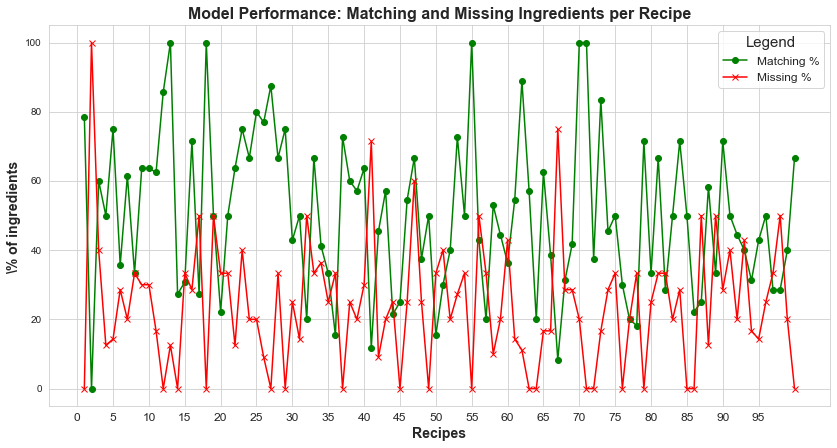

In [63]:
evaluate(ground_truth, levIngred)

#### PLOT COSINE SIMILARITY RESULT

Ground Truth: 100
Model: 100
G: ['sugar', 'vegetable oil', 'eggs', 'vanilla', 'zucchini', 'applesauce', 'orange juice', 'flour', 'baking soda', 'baking powder', 'salt', 'nutmeg', 'cinnamon', 'walnuts']
M: ['sugar', 'vegetable oil', 'eggs', 'bananas', 'orange juice', 'flour', 'baking powder', 'baking soda', 'salt', 'walnuts']
Common:  ['orange juice', 'flour', 'eggs', 'sugar', 'baking soda', 'salt', 'baking powder', 'vegetable oil', 'walnuts']
Missing: ['bananas']
G: ['white chocolate baking squares', 'nutter butter sandwich cookies', 'red sugar crystals', 'vanilla chips', 'miniature semisweet chocolate chips', 'red-hot candies']
M: ['nutter butter sandwich cookies', 'white chocolate chips', 'semisweet mini chocolate chips']
Common:  ['nutter butter sandwich cookies']
Missing: ['semisweet mini chocolate chips', 'white chocolate chips']
G: ['beef roast', 'french onion soup', 'cream of mushroom soup', 'dry red wine', 'fresh mushrooms']
M: ['stewing beef', 'cream of mushroom soup', 'fresh 

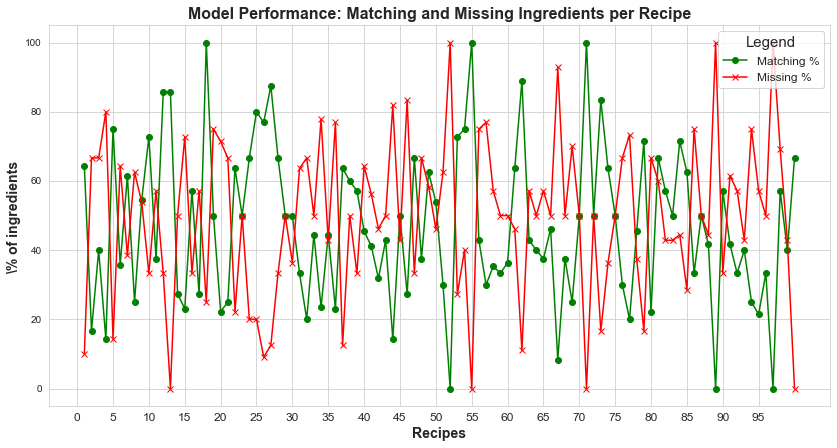

In [64]:
evaluate(ground_truth, cosineIngred)